# TP1 - Séquence de lemmes vers formes de surface

### IFT6285 - Traitement automatique des langues naturelles

### Patrice Béchard (20019173)


The full report on this project and the data is available on [Github](https://github.com/patricebechard/NLP_H18/tree/master/tp1).

--------------------

Directories where the data is stored

In [1]:
TRAINDIR = '/wikipedia_data/train/'
DEVDIR = '/wikipedia_data/dev/'
TESTDIR = '/wikipedia_data/test/'

SAVEDIR = './'

### Creating reference dictionaries, lookup tables and corpus

##### Importing modules

In [180]:
import os
import json
import gzip
import pickle
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division

##### Reference dic that maps lemmatized to all of its surface forms

In [4]:
lem2og = {}

In [5]:
def loop_over_files(dir):

    for f in os.listdir(dir):
        #looping over all files in the directory

        if f == '.DS_Store':
            #file in every directory in MacOS. We skip it here.
            continue
        
        filename = dir + f
        with gzip.open(filename, 'rb') as g:
            for line in g:
                line = line.strip().split()
                if len(line) == 2:
                    store_in_dic(line)

In [6]:
def store_in_dic(line):

    lemmatized = line[1].decode('latin1')
    original = line[0].decode('latin1')

    if lemmatized not in lem2og:
        lem2og[lemmatized] = {}

    if original not in lem2og[lemmatized]:
        lem2og[lemmatized][original] = 1
    else:
        lem2og[lemmatized][original] += 1

In [7]:
loop_over_files(TRAINDIR)

with open(SAVEDIR + 'lem2og_train.json', 'w') as fp:
    json.dump(lem2og, fp)

In [12]:
loop_over_files(DEVDIR)

with open(SAVEDIR + 'lem2og_traindev.json', 'w') as fp:
    json.dump(lem2og, fp)

##### Lookup tables from int to word and vice versa for lemmatized and surface forms

In [57]:
word2ix_lem = {"UNK": 0}
ix2word_lem = {"0": "UNK"}

word2ix_og = {"UNK": 0}
ix2word_og = {"0": "UNK"}

In [58]:
with open(SAVEDIR + 'lem2og_train.json') as json_data:
    lem2og = json.load(json_data)

In [59]:
def create_word2ix_ix2word_dic(reference_dic):
    
    ix_lem = 1
    ix_og = 1
    for lem_word in reference_dic:
        
        word2ix_lem[lem_word] = ix_lem
        ix2word_lem[ix_lem] = lem_word
        ix_lem += 1
        
        for og_word in reference_dic[lem_word]:
            word2ix_og[og_word] = ix_og
            ix2word_og[ix_og] = og_word
            ix_og += 1
            
    

In [60]:
create_word2ix_ix2word_dic(lem2og)

with open(SAVEDIR + 'word2ix_lem.json', 'w') as fp:
    json.dump(word2ix_lem, fp)
    
with open(SAVEDIR + 'ix2word_lem.json', 'w') as fp:
    json.dump(ix2word_lem, fp)

with open(SAVEDIR + 'word2ix_og.json', 'w') as fp:
    json.dump(word2ix_og, fp)

with open(SAVEDIR + 'ix2word_og.json', 'w') as fp:
    json.dump(ix2word_og, fp)

##### Corpuses consisting of a list of dictionaries containing the lemmatized form and its associated surface form. Represented as list of ints (from lookup tables)

In [91]:
def create_corpus(dir, name='train', max_n_slices=50):
    
    corpus = []
    
    n_slices = 0
    n_docs = 0
    
    for f in os.listdir(dir):
        
        if not name == 'test':
            #the test set is all in the same file, others are split in groups of 50 slices

            if n_slices >= max_n_slices:
                save_corpus(corpus, n_docs, name)
                corpus = []
                n_docs += 1
                n_slices = 0
            else:
                n_slices += 1
        
        if f == '.DS_Store':
            # unwanted mac os file
            continue
        
        filepath = dir + f
        with gzip.open(filepath, mode='rb') as g:
            og_sentence = []
            lem_sentence = []
            for line in g:
                line = line.strip().split()
                if len(line) == 2:
                    # if not 2 words in line, we don't want it!
                    
                    lemmatized = line[1].decode('latin1')
                    original = line[0].decode('latin1')
                    
                    if lemmatized not in word2ix_lem:
                        #unknown lem word, put as string
                        lem_sentence.append(lemmatized)
                    else:
                        lem_sentence.append(word2ix_lem[lemmatized])
                    
                    if original not in word2ix_og:
                        #unknown og word, put as string
                        og_sentence.append(original)
                    else:
                        og_sentence.append(word2ix_og[original])
                    
                    if original == '.':
                        corpus.append({})
                        corpus[-1]['lem'] = lem_sentence
                        corpus[-1]['og'] = og_sentence
                        lem_sentence = []
                        og_sentence = []
    
    if corpus != []:
        save_corpus(corpus, n_docs, name)
        corpus = []

def save_corpus(corpus, n_docs, name):
    
    if name == 'test':
        corpus_fname = SAVEDIR + name + '.pkl'
    else:
        corpus_fname = SAVEDIR + name + '_' + str(n_docs) + '.pkl'
    with open(corpus_fname, 'wb') as cp:
        pickle.dump(corpus, cp)
        

In [ ]:
create_corpus(TRAINDIR)

In [ ]:
create_corpus(DEVDIR, name='dev')

In [94]:
create_corpus(TESTDIR, name='test')

##### Loading reference dictionaries and lookup tables

In [148]:
with open(SAVEDIR + 'lem2og_train.json') as fp:
    lem2og = json.load(fp)

with open(SAVEDIR + 'lem2og_traindev.json') as fp:
    lem2og_traindev = json.load(fp)

with open(SAVEDIR + 'word2ix_lem.json') as fp:
    word2ix_lem = json.load(fp)

with open(SAVEDIR + 'ix2word_lem.json') as fp:
    ix2word_lem = json.load(fp)
    
with open(SAVEDIR + 'word2ix_og.json') as fp:
    word2ix_og = json.load(fp)
    
with open(SAVEDIR + 'ix2word_og.json') as fp:
    ix2word_og = json.load(fp)


### Benchmark 1

The first model we look at is a simple benchmark where we assume that the original form of the word is the same as the lemmatized form. We evaluate this model on the various datasets.

In [ ]:
def benchmark1(dir):
    
    total_n_words = 0
    total_n_correct = 0
    
    for f in os.listdir(dir):
        if f == '.DS_Store':
            continue
        
        n_words = 0
        n_correct = 0
        
        fname = dir + f
        with gzip.open(fname, 'rb') as g:
            
            for line in g:
                line = line.strip().split()
                if len(line) == 2:
                    total_n_words += 1
                    if line[0] == line[1]:
                        total_n_correct += 1
    return total_n_correct / total_n_words

In [ ]:
acc_train = benchmark1(TRAINDIR)
print("Training accuracy : %.2f" % (acc_train * 100))

Training accuracy : 65.24


In [ ]:
acc_dev = benchmark1(DEVDIR)
print("Dev accuracy : %.2f" % (acc_dev * 100))

Dev accuracy : 64.78


In [ ]:
acc_test = benchmark1(TESTDIR)
print("Test accuracy : %.2f" % (acc_test * 100))

Test accuracy : 64.95


### Most-frequent word approach

The second model we look at is a model inspired by Charniak *et. al.* (1993). The task they worked on was Part-of-Speech tagging and they used a model which return the most probable tag for a given word. In our case, we return the most probable surface form for every lemmatized form of a word. If the lemmatized word is not in the reference dictionary that maps a lemmatized form to all of its surface forms, we return the lemmatized form as the surface form.

In [ ]:
def benchmark2(dir):
    
    total_n_words = 0
    total_n_correct = 0

    for f in os.listdir(dir):
        #looping over all files in the directory
        if f == '.DS_Store':
            #file in every directory in MacOS. We skip it here.
            continue
            
        fname = dir + f
            
        with gzip.open(fname, 'rb') as g:

            for line in g:
                line = line.strip().split()
                if len(line) == 2:
                    total_n_words += 1

                    lemmatized = line[1].decode('latin1')
                    original = line[0].decode('latin1')

                    if lemmatized in lem2og:
                        # word is in the dictionary, we return the most probable form
                        word = lem2og[lemmatized]
                        choice = max(word, key=word.get)
                        if choice == original:
                            total_n_correct += 1
                    else:
                        # word is not in the dictionary, we return same word as the input
                        if original == lemmatized:
                            total_n_correct += 1

    return total_n_correct / total_n_words              


In [ ]:
acc_train = benchmark2(TRAINDIR)
print("Training accuracy : %.2f" % (acc_train * 100))

Training accuracy : 80.67


In [ ]:
acc_dev = benchmark2(DEVDIR)
print("Dev accuracy : %.2f" % (acc_dev * 100))

Dev accuracy : 80.72


In [ ]:
acc_test = benchmark2(TESTDIR)
print("Test accuracy : %.2f" % (acc_test * 100))

Test accuracy : 80.13


### Synced Sequence to sequence model

##### Importing modules

In [72]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

import random
import pickle

use_cuda = torch.cuda.is_available()


##### Loading data

In [95]:
with open(SAVEDIR + 'train_0.pkl', 'rb') as f:
    training_set = pickle.load(f)
    
with open(SAVEDIR + 'dev_0.pkl', 'rb') as f:
    dev_set = pickle.load(f)
    
with open(SAVEDIR + 'test.pkl', 'rb') as f:
    test_set = pickle.load(f)


##### Model

In [97]:
lem_vocab_size = len(word2ix_lem)
og_vocab_size = len(word2ix_og)

In [98]:
class Lem2SurfRNN(nn.Module):

    def __init__(self, input_size, hidden_size=16, num_layers=1, batch_size=1, bidirectional=False):
        super(Lem2SurfRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        
        self.word_embeddings = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional)
        
        self.hidden = self.init_hidden()

    def forward(self, input):
        
        embeds = self.word_embeddings(input)
        output, self.hidden = self.rnn(embeds.view(len(input), 1, -1), self.hidden)
        
        return output.view(len(input), -1)
    
    def init_hidden(self):
        
        if self.bidirectional:
            depth = 2 * self.num_layers
        else:
            depth = self.num_layers
        
        hidden = Variable(torch.zeros(depth, 1, self.hidden_size))
        
        if use_cuda:
            hidden = hidden.cuda()
            
        return hidden

##### Functions

In [185]:
def train_model(model, clf_dict, ix2word_clf, n_updates=100000, print_every=100, learning_rate=1e-3, save=False, model_name='model'):
    
    start_time = time.time()
    
    if use_cuda:
        model = model.cuda()
    
    best = 0
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_acc = []
    dev_acc = []
    
    total, correct = 0, 0
    
    try:
        #we can interrupt the training with a KeyboardInterrupt (ctrl-c)
        for update in xrange(n_updates):

            # Training the model
            model.train()

            sentence = random.choice(training_set)
            
            inputs = sentence['lem']
            targets = sentence['og']

            inputs = torch.LongTensor(inputs)
            targets = torch.LongTensor(targets)

            optimizer.zero_grad()
            model.hidden = model.init_hidden()

            inputs, targets= Variable(inputs), Variable(targets)
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)

            #prediction
            loss = 0
            total += len(outputs)
            predicted_out, loss = predict_output_sequence(inputs, outputs, loss, 
                                                          clf_dict, targets=targets, criterion=criterion)
            
            n_corr = predicted_out.eq(targets.data).cpu().sum() 
            correct += n_corr

            if isinstance(loss, int):
                continue
            loss.backward()
            
            for key, value in clf_dict.items():
                # This is inefficient!
                value['optim'].step()
            optimizer.step()

            if update % print_every == 0:

                train_acc.append(100. * correct / total)

                # Evaluating the model on the dev set
                model.eval()
                total, correct = evaluate_model(model, clf_dict, dev_set)

                dev_acc.append(100. * correct / total)

                if save and (dev_acc[-1] > best):
                    best = dev_acc[-1]
                    torch.save(model.state_dict(), model_name + '.pt')
                    
                    if update > 1000:
                        total, correct = evaluate_model(model, clf_dict, test_set, n_iter=1000, test=True)
                        print("Test set accuracy : %05.2f" % (100. * correct / total))

                print("Update %d ----- Training accuracy : %05.2f ----- Dev accuracy : %05.2f" % (update, train_acc[-1], dev_acc[-1]))
                #total, correct = 0, 0
    finally:
        plot_progress(train_acc, dev_acc, print_every, model_name=model_name)
        
        stop_time = time.time()
        
        hours, rem = divmod(stop_time - start_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Model was trained during : {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

    return train_acc, dev_acc

In [178]:
def predict_output_sequence(inputs, outputs, loss, clf_dict, eval=False, targets=None, criterion=None):
    
    predicted_out = []

    for i in range(len(outputs)):
    
        #first scheme. if lemmatized word not in vocabulary, return lemmatized as surface
        input_word = int(inputs[i])
        if input_word == 0:
            # UNKNOWN WORD
            predicted_out.append(input_word)
            continue

        input_word = ix2word_lem[str(int(inputs[i]))]
        tmp = lem2og[input_word]
        #second scheme. when only one mapping, map directly to it        
        if len(tmp) == 1:
            pred = word2ix_og[tmp.keys()[0]]

        #third scheme. custom classifier
        elif input_word in clf_dict:
            """
            At training time, we take the target word index and find to which 
            output neuron it relates. We then compute the loss for the small model.
            
            For both training and evaluation time, we then find which word does the 
            output neuron with max value relate to and map it (og index)
            
            This is easier for gradient descent.
            """
            
            custom_clf = clf_dict[input_word]['clf']
            if use_cuda:
                custom_clf = custom_clf.cuda()
            pred_vector = custom_clf(outputs[i]).unsqueeze(0)
            
            if not eval:
                # training time for gradient propagation
                target_word = ix2word_og[str(int(targets[i]))]
                clf_ix = Variable(torch.LongTensor([ix2word_clf[input_word].index(target_word)]))
                if use_cuda:
                    clf_ix = clf_ix.cuda()
            
                loss += criterion(pred_vector, clf_ix)

            _, pred_neuron = torch.max(pred_vector, 1)
            pred_neuron = int(pred_neuron)

            pred = ix2word_clf[input_word][pred_neuron]
            pred = word2ix_og[pred]
                
        #fourth scheme. Return most probable word
        else:
            possible = lem2og[input_word]
            pred = word2ix_og[max(possible, key=possible.get)]

        predicted_out.append(pred)
    
    predicted_out = torch.LongTensor(predicted_out)
    if use_cuda:
        predicted_out = predicted_out.cuda()

    return predicted_out, loss

In [80]:
def create_clf_dict(dataset, most_freq, hidden_size=32, learning_rate=1e-3):
    
    clf_dict = {}
    ix2word_clf = {}
    
    for word in most_freq:
        output_size = len(dataset[word])
        clf_dict[word] = {}
        clf_dict[word]["clf"] =  nn.Linear(in_features=hidden_size, out_features=output_size)
        clf_dict[word]["optim"] = optim.Adam(clf_dict[word]["clf"].parameters(), lr=learning_rate)
        
        ix2word_clf[word] = dataset[word].keys()
        
    return clf_dict, ix2word_clf

In [163]:
def evaluate_model(model, clf_dict, dataset, n_iter=100, test=False):
    
    correct = 0
    total = 0
    
    if test:
        #loop overt all dataset (else only approximate of accuracy)
        n_iter = len(dataset)

    for i in range(n_iter):

        if test:
            sentence = dataset[i]
        else:
            sentence = random.choice(dataset)
            
        unknown_words_lem = []
        unknown_words_og = []
            
        for j in range(len(sentence['lem'])):
            if type(sentence['lem'][j]) != int:
                unknown_words_lem.append(sentence['lem'][j])
                sentence['lem'][j] = 0 #mapped as UNK
                
        for j in range(len(sentence['og'])):
            if type(sentence['og'][j]) != int:
                unknown_words_og.append(sentence['og'][j])
                sentence['og'][j] = 0
                
        inputs = sentence['lem']
        targets = sentence['og']

        inputs = torch.LongTensor(inputs)
        targets = torch.LongTensor(targets)

        model.hidden = model.init_hidden()

        inputs, targets= Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        
        loss = 0
        total += len(outputs)   
        
        predicted_out, _ = predict_output_sequence(inputs, outputs, 
                                                      loss, clf_dict, eval=True)
        
        correct += predicted_out.eq(targets.data).cpu().sum() 
    
        if i == 0 and test:
            show_translation(inputs, predicted_out, targets, unknown_words_lem, unknown_words_og)
        
    return total, correct

In [157]:
def show_translation(inputs, predicted, targets, unknown_words_lem, unknown_words_og):
    
    input_str = ''
    pred_str = ''
    target_str = ''
    
    in_sentence = list(inputs.data)
    pred_sentence = list(predicted)
    target_sentence = list(targets.data)
    
    for i in range(len(inputs)):
        
        #input sentence
        if in_sentence[i] == 0:
            unk_word = unknown_words_lem.pop(0)
            input_str += unk_word + ' '
            pred_str += unk_word + ' '
        else:
            input_str += ix2word_lem[str(in_sentence[i])] + ' '
            pred_str += ix2word_og[str(pred_sentence[i])] + ' '
        
        if target_sentence[i] == 0:
            target_str += unknown_words_og.pop(0)
        else:
            target_str += ix2word_og[str(target_sentence[i])] + ' '

    print("Input     : %s" % input_str)
    print("Predicted : %s" % pred_str)
    print("Target    : %s" % target_str)
    

In [82]:
def plot_progress(train_acc, dev_acc, print_every, model_name='model'):
    
    if len(train_acc) != len(dev_acc):
        #last update wasnt saved
        train_acc = train_acc[:-1]
    
    #save progress
    np.savetxt(model_name + '_progress.txt', np.array([train_acc, dev_acc]))
    
    # scale to nb of updates
    rng = np.arange(len(train_acc)) * print_every
           
    plt.plot(rng, np.array(train_acc), label='Training accuracy')
    plt.plot(rng, np.array(dev_acc), label='Dev accuracy')
    plt.xlabel("Number of updates")
    plt.ylabel("Accuracy (%)")
    plt.legend(fancybox=True, loc=4)
    plt.savefig(model_name + "_progress.png")
    plt.show()
    

In [83]:
def keep_n_most_freq_words(dataset, thres=10000):
    
    n_words = 0
    min_occurence = 1e9
    
    most_frequent_words = {}
    
    for key, value in dataset.items():
        
        n_occurence = sum(value.values())
        
        if n_words < thres:
            #add words until max capacity
            n_words += 1
            most_frequent_words[key] = n_occurence
            
            if n_occurence < min_occurence:
                min_occurence = n_occurence
                less_common_word = key
        
        elif n_occurence > min_occurence:
            #max capacity achieved, only keep if n_occurences is big enough
            
            del most_frequent_words[less_common_word]
            most_frequent_words[key] = n_occurence
            
            less_common_word = min(most_frequent_words, key=most_frequent_words.get)
            min_occurence = most_frequent_words[less_common_word]

    return most_frequent_words

most_freq = keep_n_most_freq_words(lem2og)

Building the model...
Training the model...
Update 0 ----- Training accuracy : 49.43 ----- Dev accuracy : 30.65
Update 100 ----- Training accuracy : 34.69 ----- Dev accuracy : 49.21
Update 200 ----- Training accuracy : 54.31 ----- Dev accuracy : 61.67
Update 300 ----- Training accuracy : 63.10 ----- Dev accuracy : 66.72
Update 400 ----- Training accuracy : 66.77 ----- Dev accuracy : 68.44
Update 500 ----- Training accuracy : 67.84 ----- Dev accuracy : 71.62
Update 600 ----- Training accuracy : 70.42 ----- Dev accuracy : 72.27
Update 700 ----- Training accuracy : 72.16 ----- Dev accuracy : 75.09
Update 800 ----- Training accuracy : 74.18 ----- Dev accuracy : 72.68
Update 900 ----- Training accuracy : 72.92 ----- Dev accuracy : 72.97
Update 1000 ----- Training accuracy : 72.48 ----- Dev accuracy : 74.11
Input     : facemelter be the twelfth studio album by american hard rock/heavy metal band y&t , which be release on may 21 , 2010 through the frontiers records label . 
Predicted : Faceme

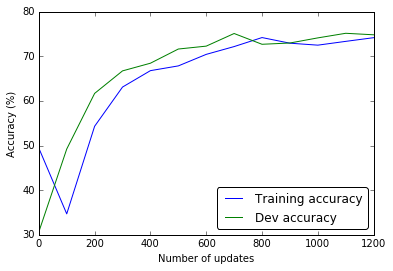

Model was trained during : 00:23:39.15


KeyboardInterrupt: 

In [187]:
hidden_size = 32
n_layers = 1
bidirectional = True
learning_rate=1e-4
if bidirectional:
    model_name = SAVEDIR + "mdl_%d_%d_bi" % (hidden_size, n_layers)
else:
    model_name = SAVEDIR + "mdl_%d_%d" % (hidden_size, n_layers)

print("Building the model...")

#creating the basic model
model = Lem2SurfRNN(input_size=lem_vocab_size, hidden_size=hidden_size, bidirectional=bidirectional)
#and the custom classifiers
if bidirectional:
    out_rnn_size = hidden_size * 2
else:
    out_rnn_size = hidden_size
clf_dict, ix2word_clf = create_clf_dict(lem2og, most_freq, hidden_size=out_rnn_size, learning_rate=learning_rate)

print("Training the model...")
train_model(model, clf_dict, ix2word_clf, learning_rate=learning_rate, model_name=model_name, save=True)


In [ ]:
model.load_state_dict(torch.load('models_data/mdl_32_1_bi_sv.pt'))

correct_tr, total_tr = evaluate_model(model, clf_dict, training_set)
print(100 * correct_tr / total_tr)
evaluate_model(model, clf_dict, test_set, test=True)

In [ ]:
torch.cuda.empty_cache()

### Data analysis

##### Length of vocabulary

In [5]:
def length_of_vocab(dataset):
    
    lem_length = len(dataset)
    og_length = 0
    
    for key, value in dataset.items():
        og_length += len(value)
        
    print("Number of unique lemmatized words : %d " % lem_length)
    print("Number of unique original words : %d " % og_length)

In [6]:
length_of_vocab(lem2og)

Number of unique lemmatized words : 3618127 
Number of unique original words : 4154606 


In [7]:
length_of_vocab(lem2og_traindev)

Number of unique lemmatized words : 4296129 
Number of unique original words : 4928238 


##### Number of mappings per words

In [8]:
def n_multiple_words(dataset):
    
    n_of_multiple_words = np.zeros(100)
    for key, value in dataset.items():

        n_of_multiple_words[len(value)] += 1

    return n_of_multiple_words

In [9]:
word_freq = n_multiple_words(lem2og)
unique_freq = word_freq[1] / np.sum(word_freq)
print("Fraction of dataset with only one possible mapping : %.4f" % unique_freq)

Fraction of dataset with only one possible mapping : 0.9020


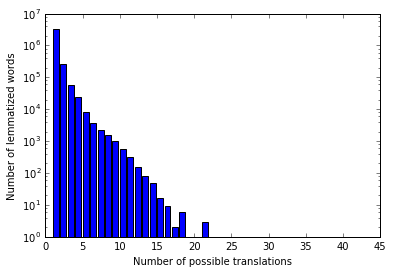

In [14]:
word_freq = np.trim_zeros(word_freq)

plt.clf()
plt.bar(np.arange(len(word_freq)) + 1, word_freq)
plt.yscale('log', nonposy='clip')
plt.xlabel("Number of possible translations")
plt.ylabel("Number of lemmatized words")
plt.savefig('word_freq.png')
plt.show()

##### Frequency of words in corpus

In [11]:
def frequency_of_words_in_corpus(dataset):
    
    lemmas_freq = []
    
    for key, value in dataset.items():

        n_times = sum(value.values())
        lemmas_freq.append(n_times)

    return np.array(lemmas_freq)

In [12]:
lemmas_freq = frequency_of_words_in_corpus(lem2og)

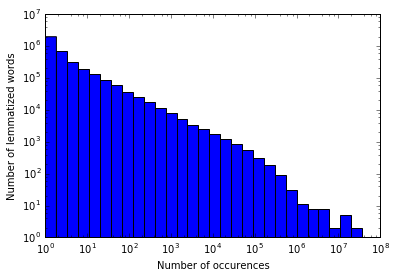

In [13]:
max_freq = max(lemmas_freq)


plt.clf()
plt.hist(lemmas_freq, bins=np.logspace(0, np.log10(max_freq), 30))
plt.xscale("log")
plt.yscale("log", nonposy='clip')
plt.xlabel("Number of occurences")
plt.ylabel("Number of lemmatized words")
plt.savefig('occurence.png')
plt.show()

In [15]:
def count_n_most_frequent_words(lemmas_freq, thres):
    total_number_of_words = np.sum(lemmas_freq)

    n_accumulated = 0
    frac = 0
    n_words = 0
    lem_freq_sorted = sorted(lemmas_freq)

    while frac < thres:

        n_words += 1
        n_accumulated += lem_freq_sorted[-n_words]
        frac = n_accumulated / total_number_of_words

    return n_words   


In [16]:
thres = 0.9
print(" The %d most frequent words correspond to %.2f%% of the dataset" % 
      (count_n_most_frequent_words(lemmas_freq, thres), thres))


 The 8553 most frequent words correspond to 0.90% of the dataset


In [17]:
thres = 0.95
print(" The %d most frequent words correspond to %.2f%% of the dataset" % 
      (count_n_most_frequent_words(lemmas_freq, thres), thres))


 The 31582 most frequent words correspond to 0.95% of the dataset
